# Model Parameterization and Evaluation

## Metabolic Model Inputs

### Packages

In [2]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.decomposition import PCA 
import umap
import hdbscan

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Visualization
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

filter = df["ec"].str.contains("-") # filter non-specific ec numbers, e.g., 1.1.1.-
df = df[~filter]

df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]

df_train

ec,taxon_id,media_id,1.1.1.1,1.1.1.100,1.1.1.101,1.1.1.102,1.1.1.103,1.1.1.105,1.1.1.107,1.1.1.108,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,100.0,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,J386,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100225.0,J233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002526.0,J22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004166.0,1a,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,99655.0,J386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8460,99675.0,J14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8461,99675.0,J84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8462,99807.0,J26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Testing parameters

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, silhouette_score

# Split the datasets into training and test sets
TARGET = "taxon_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Model validation with only labeled samples from data.ipynb
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["taxon_id", "media_id"], axis=1),
    df_train[TARGET],
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: scale data
    ('pca', PCA(n_components=120)),  # Reduce dimensionality with PCA
    ('umap', umap.UMAP(  # UMAP step
        metric="euclidean",
        n_epochs=200,
        random_state=RANDOM_SEED,
        n_jobs=1
    ))
])

# Define parameter grid with correct step names
param_distributions = {
    'umap__n_components': [10, 20, 30, 50],
    'umap__n_neighbors': [40, 50, 60, 70], 
    'umap__min_dist': [0, 0.2, 0.4, 0.6]
}

# Custom scorer function
def umap_silhouette(X, y):
    embedding = X  # X here is already the transformed data by UMAP
    return silhouette_score(embedding, y)

# Wrap the custom scorer
scorer = make_scorer(umap_silhouette, greater_is_better=True)

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring=scorer
)

# Fit the search to your data
search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = search.best_params_
best_model = search.best_estimator_

print("Best Parameters:", best_params)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'umap__n_neighbors': 40, 'umap__n_components': 30, 'umap__min_dist': 0.4}


### Pipeline

In [22]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Model validation with only labeled samples from data.ipynb
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["taxon_id", "media_id"], axis=1),
    df_train[TARGET],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [6]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Scale data (optional)
    ('pca', PCA(n_components=120)),   # Reduce dimensionality with PCA
    ('umap', umap.UMAP(              # Further reduce with UMAP
        metric="euclidean",
        n_epochs=200, #200 recommended for large datasets, higher => stricter clustering
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=30,
        n_neighbors=40,
        min_dist=0.4
        )) 
])

### Fit and transform

In [7]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Optimizing n_clusters

In [8]:
# Silhouette coefficient method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Test a range of clusters for their silhouette coefficients
clusters = []
for n_cluster in range(10, 200):
    kmeans = KMeans(n_clusters=n_cluster).fit(X_train_transformed)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_train_transformed, label, metric='euclidean')
    clusters.append({'n_clusters': n_cluster, 'coefficient': sil_coeff})

# Select the maximum coefficient
clusters = pd.DataFrame(clusters)
c = clusters.iloc[clusters["coefficient"].argmax()]["n_clusters"]
s = clusters["coefficient"].max()
n = int(c)

print("{} clusters returns a maximum Silhouette Coefficient of {}".format(n, s))

173 clusters returns a maximum Silhouette Coefficient of 0.6888360381126404


In [9]:
# Cluster using maximum coefficient's n_clusters
clusterer = KMeans(n_clusters=n, random_state=RANDOM_SEED)
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [10]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
print(f"Total PCA explained variance: {explained_variance.sum()}")

# Further dimensionality reduction and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}")
    # Silhouette score <=0.25 implies poor clustering, 0.25<x<=0.50 is fair, <50 is good

Total PCA explained variance: 0.8536006634125857
173 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.6803547739982605


In [11]:
# Compare to hdbscan clustering 

# Apply HDBSCAN clustering on the transformed training data
hclusterer = hdbscan.HDBSCAN(
    min_samples=5, 
    min_cluster_size=15, 
    #gen_min_span_tree=True, 
    prediction_data=True # cluster_selection_method="leaf", for more fine-grained clustering
)
hcluster_labels = hclusterer.fit_predict(X_train_transformed)

# Clustering performance (UMAP and hdbscan)
hsilhouette_avg = silhouette_score(X_train_transformed, hcluster_labels)
print(hclusterer.labels_.max(), "hdbscan training clusters")
print(f"Silhouette Score on hdbscan clusters: {hsilhouette_avg}")

# Convert to numpy array for hdbscan and predict clustering
#test_points = test_df[["Component 1", "Component 2"]].to_numpy()
#test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)

# Optional constraints
#filtered = train_df[train_df['Cluster'] >= 0]
#test_labels = clusterer.fit_predict(X_test_transformed)

138 hdbscan training clusters
Silhouette Score on hdbscan clusters: 0.5238796472549438


## Classifier

In [12]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [13]:
y2_train = cluster_labels
y2_test = test_clusters

### Random Forest

In [14]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[ 14 142   9 ...  92  95 104]


In [15]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.87      1.00      0.93        13
           2       1.00      0.98      0.99        44
           3       1.00      1.00      1.00         7
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00        52
           7       1.00      1.00      1.00        41
           8       1.00      1.00      1.00        27
           9       1.00      1.00      1.00        34
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00        15
          17       1.00    

### Nearest Neighbors

In [16]:
knc= KNeighborsClassifier(n_neighbors=10)
knc.fit(X_train_transformed, cluster_labels)
distances, indices = knc.kneighbors(X_test_transformed)

print(knc.predict(X_test_transformed))

[ 14 142   9 ...  92  33 104]


In [17]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.76      1.00      0.87        13
           2       1.00      1.00      1.00        44
           3       1.00      0.86      0.92         7
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00        52
           7       1.00      1.00      1.00        41
           8       1.00      1.00      1.00        27
           9       1.00      0.94      0.97        34
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00        15
          17       1.00    

## Feature Importance

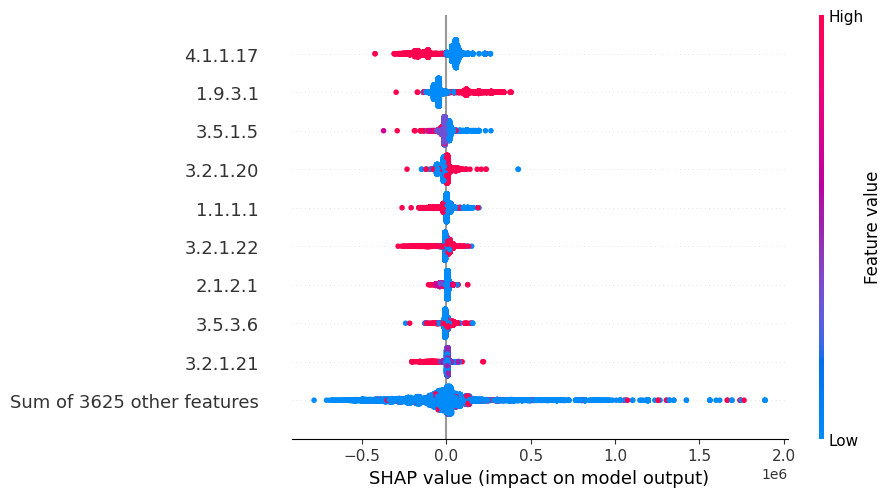

In [21]:
import xgboost
import shap

XG_train = df_train.drop(["taxon_id", "media_id"], axis=1)
yG_train = df_train["taxon_id"]

# train an XGBoost model
model2 = xgboost.XGBRegressor().fit(XG_train, yG_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model2)
shap_values = explainer(XG_train)

shap.plots.initjs()
shap.plots.beeswarm(shap_values)

# Media Clusters

Optimization functions ran in a separate notebook, dimensionality reduction and clustering parameters yielded a maximum Silhouette Score

In [3]:
media_df = pd.read_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), low_memory=False)

media_df = media_df.dropna(subset='component_id', how='any')
media_df['component_id'] = media_df['component_id'].astype(int)
media_df = media_df[["taxon_id", "media_id", "component_id"]].value_counts().reset_index()
media_df = media_df.pivot(index=["taxon_id", "media_id"], columns="component_id", values="count")
media_df = media_df.fillna(0.0).reset_index()

media_df.head()

component_id,taxon_id,media_id,4,18,33,37,46,47,60,68,...,240,337,430,497,506,616,688,754,1353,1359
0,24.0,J22,8.0,2.0,0.0,0.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,J26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,J167,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,J306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51.0,J443,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
TARGET_VAR = "taxon_id" # media_id string issues, try to replace as categorical data
RANDOM_SEED = 47

X_train, X_test, y_train, y_test = train_test_split(
    media_df.drop(["taxon_id", "media_id"], axis=1),
    media_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [6]:
reducer = umap.UMAP(
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_neighbors=30,
        n_components=10,
        min_dist=0.4
    )

reduced = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(reduced, columns=[f"Component {i+1}" for i in range(reduced.shape[1])])

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
0,-1.773724,13.579668,3.121752,-0.064388,10.343656,8.856904,6.277681,9.242080,2.203150,3.557396
1,-2.630010,-3.703500,8.822997,2.021324,5.997718,-0.941044,5.681618,9.451844,5.813793,1.553398
2,-1.843176,13.483267,3.120849,-0.037890,10.300418,8.939775,6.300568,9.165531,2.090676,3.521620
3,3.028028,-0.327541,4.283557,3.880607,4.224166,3.252759,5.283535,10.281306,7.387136,3.712514
4,-1.789177,13.412326,3.061722,-0.025458,10.267249,8.859686,6.407624,9.193830,2.177684,3.675980


In [7]:
cluster = KMeans(
    n_clusters=12,
    random_state=RANDOM_SEED
)

reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)
reduced_df[["taxon_id", "media_id"]] = media_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df.to_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"), index=False)
reduced_df.head()

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Cluster,taxon_id,media_id
0,-1.773724,13.579668,3.121752,-0.064388,10.343656,8.856904,6.277681,9.242080,2.203150,3.557396,10,134375.0,J27
1,-2.630010,-3.703500,8.822997,2.021324,5.997718,-0.941044,5.681618,9.451844,5.813793,1.553398,5,1448267.0,J26
2,-1.843176,13.483267,3.120849,-0.037890,10.300418,8.939775,6.300568,9.165531,2.090676,3.521620,10,344163.0,J26
3,3.028028,-0.327541,4.283557,3.880607,4.224166,3.252759,5.283535,10.281306,7.387136,3.712514,11,29429.0,J22
4,-1.789177,13.412326,3.061722,-0.025458,10.267249,8.859686,6.407624,9.193830,2.177684,3.675980,10,43057.0,J198


In [9]:
# Plot the training points
fig = px.scatter(
    data_frame = reduced_df,
    x = "Component 1",
    y = "Component 2",
    color = "Cluster",
    hover_data = ["taxon_id", "media_id"],
    opacity = 0.3
) 

fig.update_layout(
    title="Media Clusters (12 dimensions)",
    template="plotly_white"
)

fig.show()